In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product
import warnings

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('WAG_C_M.csv', sep = ';', index_col = ['month'], parse_dates = ['month'],
                   dayfirst = True)
data.columns = ['wage']
data

,wage
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
...,...
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 284 entries, 1993-01-01 to 2016-08-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wage    284 non-null    float64
dtypes: float64(1)
memory usage: 4.4 KB


# Анализ ряда

Построим график нашего ряда.

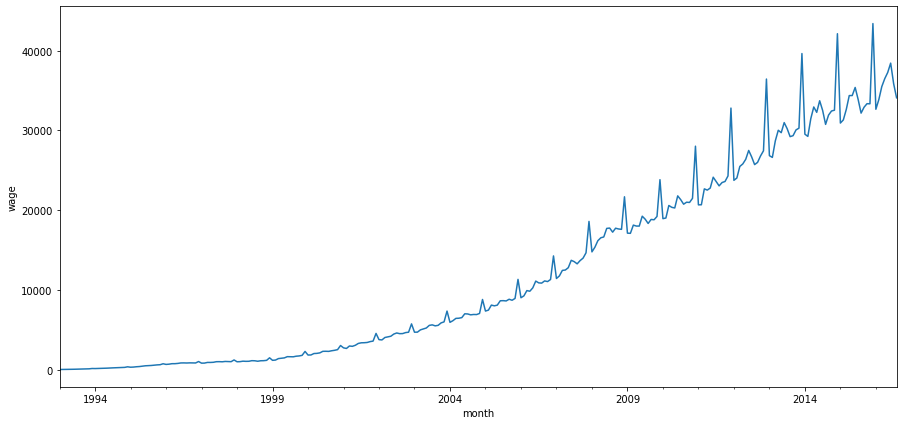

In [4]:
plt.figure(figsize = (15, 7))
data.wage.plot()
plt.ylabel('wage')
plt.show()

<Figure size 1080x720 with 0 Axes>

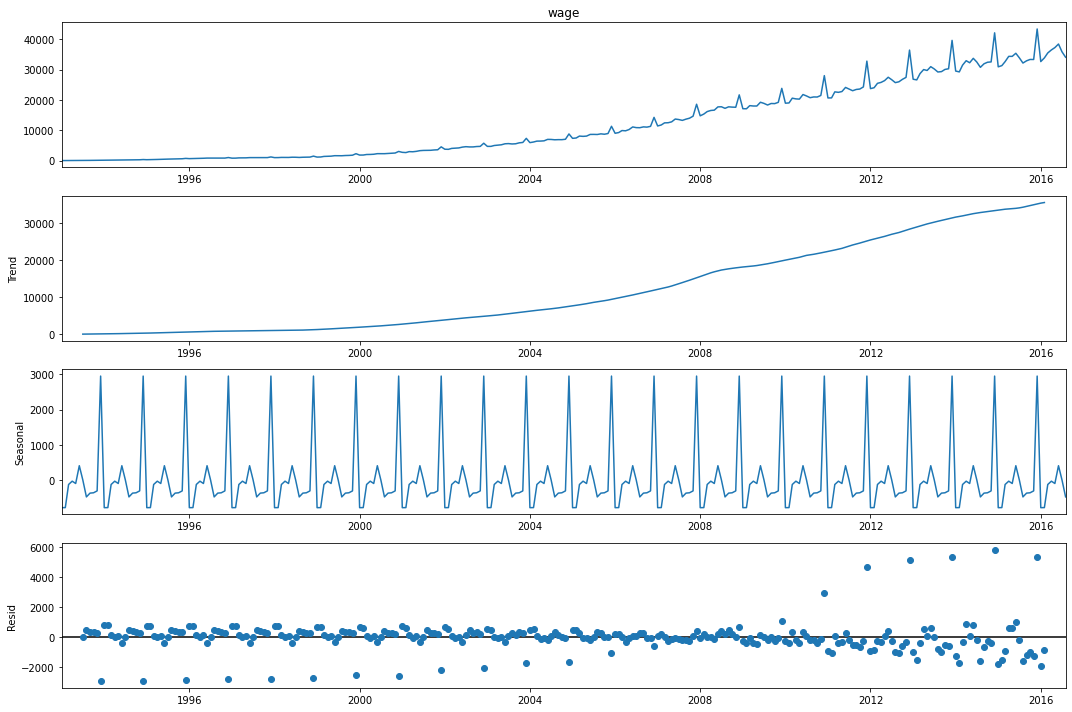

In [5]:
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(data.wage).plot()
plt.show()

Ряд имеет возрастающий тренд и годовую сезонность. Дисперсия нестабилизирована.

### Стабилизация дисперсии

Стабилизируем дисперсию преобразованием Бокса-Кокса.

lambda = 0.263202


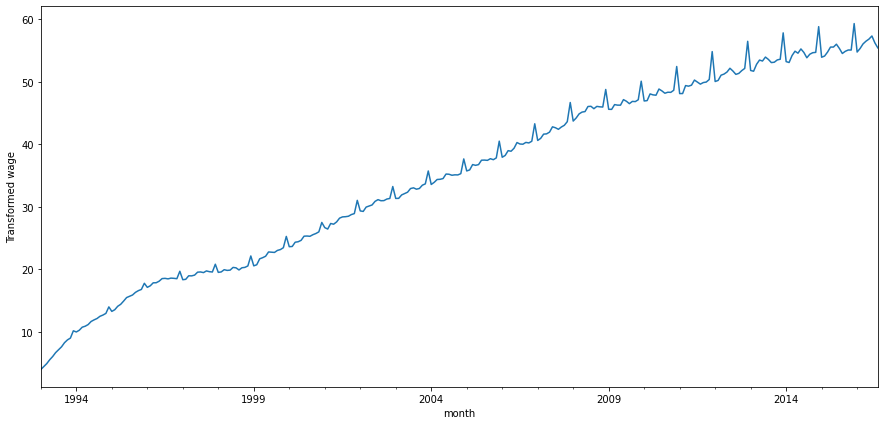

In [6]:
data['wage_box'], lambda_ = stats.boxcox(data.wage)
plt.figure(figsize = (15, 7))
data.wage_box.plot()
plt.ylabel('Transformed wage')
print('lambda = %f' % lambda_)

### Дифференцирование

Для улучшения стационарности применим сезонное дифференцирование.

In [7]:
data['wage_box_diff'] = data.wage_box - data.wage_box.shift(12) 

<Figure size 1080x720 with 0 Axes>

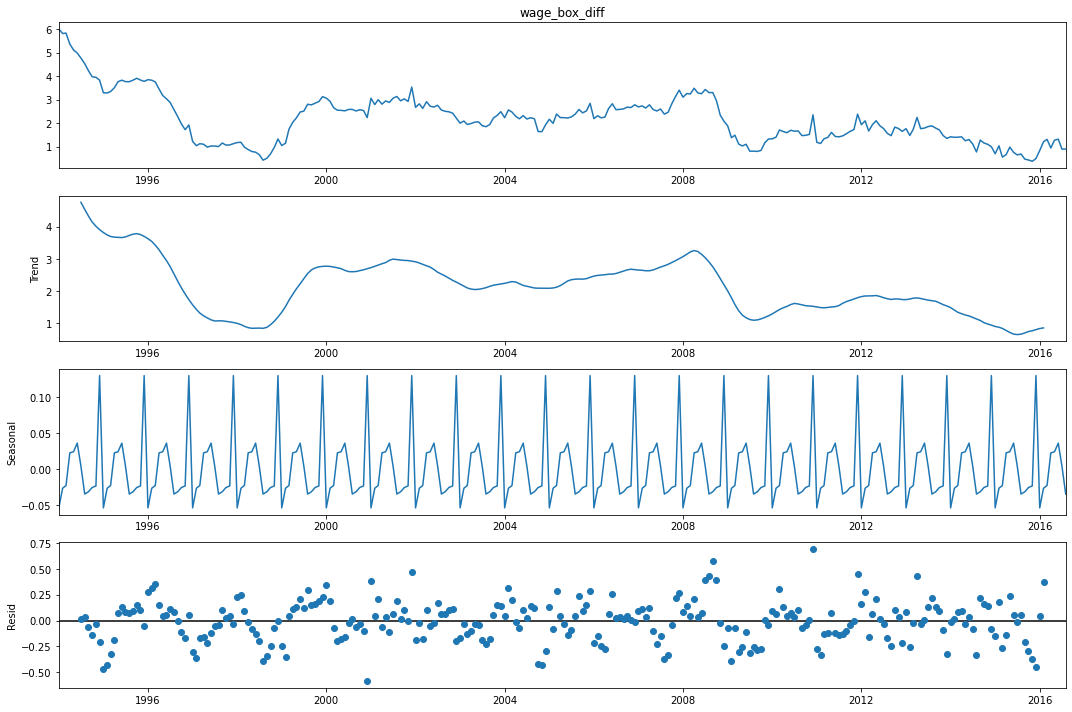

In [8]:
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(data.wage_box_diff[12:]).plot()
plt.show()

Визувально ряд все еще нестационарен. Применим обычное дифференцирование.

In [9]:
data['wage_box_diff2'] = data.wage_box_diff - data.wage_box_diff.shift(1)

<Figure size 1080x720 with 0 Axes>

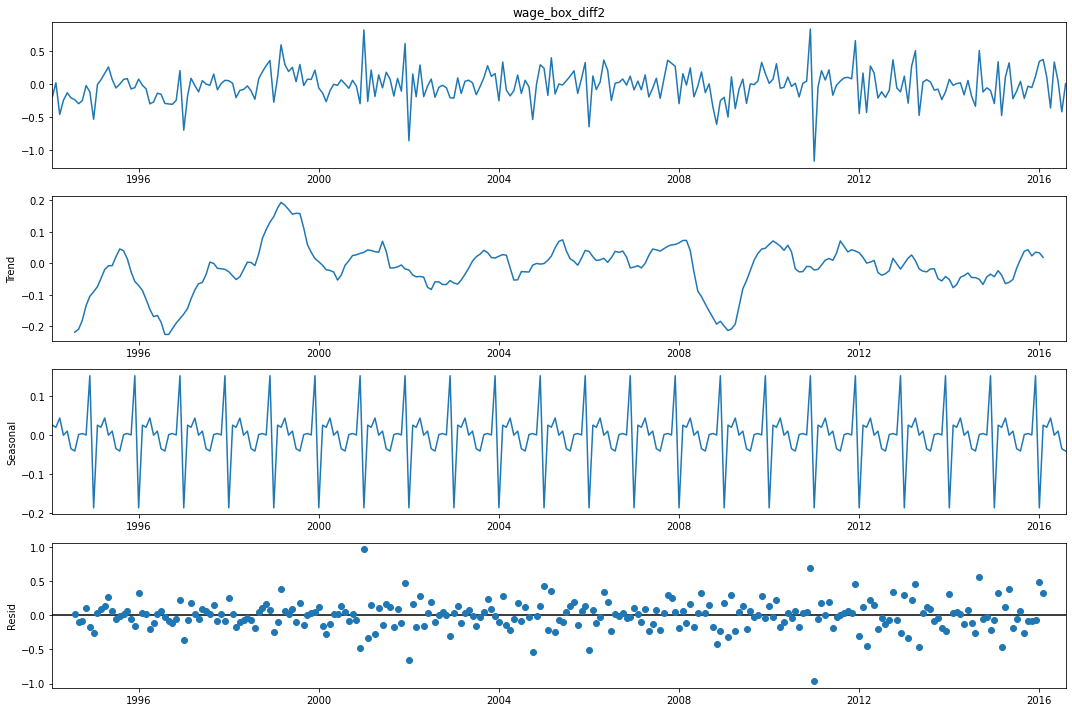

In [10]:
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(data.wage_box_diff2[13:]).plot()
plt.show()

Ряд выглядит стационарным. Проверим стационарность формально с помощью критерия Дики-Фуллера.

In [11]:
sm.tsa.stattools.adfuller(data.wage_box_diff2[13:])[1]

5.2036037158214874e-08

Гипотеза о нестационарности отвергается.

# Подбор модели

### Выбор начальных параметров

Построим ACF и PACF графики последнего получившегося ряда.

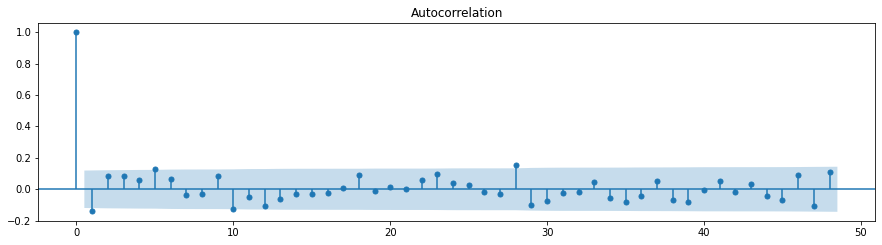

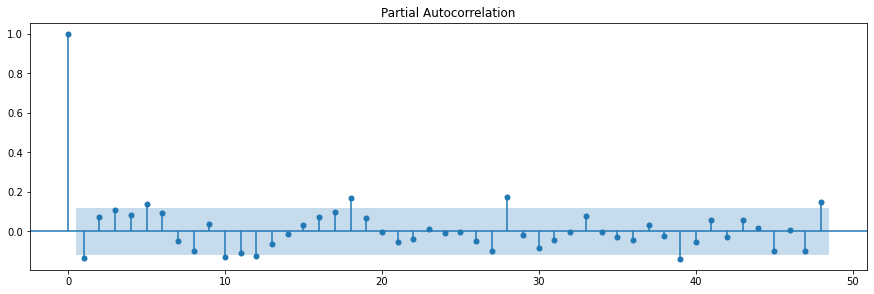

In [12]:
plt.figure(figsize = (15, 8))
ax = plt.subplot(2, 1, 1)
sm.graphics.tsa.plot_acf(data.wage_box_diff2[13:], lags = 48, ax = ax)
pylab.show()

ax = plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_pacf(data.wage_box_diff2[13:], lags = 48, ax = ax)
pylab.show()

Начальные приближения: $Q = 0, q = 1, P = 4, p = 5$. ($q$ можно было взять больше, но тогда перебор параметров получается слишком большим)

### Обучение моделей и выбор лучшей

In [16]:
ps = range(0, 6)
d=1
qs = range(0, 2)

Ps = range(0, 5)
D=1
Qs = range(0, 1)

In [17]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [18]:
%%time

results = []
best_aic = float('inf')
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model = sm.tsa.statespace.SARIMAX(data.wage_box, order = (param[0], d, param[1]),
                                          seasonal_order = (param[2], D, param[3], 12)).fit(disp = -1)
    
    except ValueError:
        print('wrong parameters:', param)
        continue
            
    aic = model.aic
    results.append([param, aic])
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
            
warnings.filterwarnings('default')

Wall time: 1min 25s


In [19]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending = True).head())

      parameters       aic
56  (5, 1, 1, 0) -5.260134
36  (3, 1, 1, 0) -4.995859
51  (5, 0, 1, 0) -4.545934
59  (5, 1, 4, 0) -4.469892
54  (5, 0, 4, 0) -4.238184


c:\users\owner\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Результаты лучшей модели.

In [20]:
best_model.summary()

c:\users\owner\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            wage_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 1)x(1, 1, [], 12)   Log Likelihood                  10.630
Date:                             Mon, 22 Feb 2021   AIC                             -5.260
Time:                                     17:11:31   BIC                             23.557
Sample:                                 01-01-1993   HQIC                             6.310
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2016      0.436      0.462      0.644      -0.653       1.057
ar.L2          0.0993      0.105      0.949      0.342      -0.106       0.304
ar.L3          0.1044      0.064      1.630      0.103      -0.021       0.230
ar.L4          0.0703      0.100      0.707      0.480      -0.125       0.265
ar.L5          0.1339      0.108      1.237      0.216      -0.078       0.346
ma.L1         -0.3923      0.439     -0.894      0.371      -1.252       0.468
ar.S.L12      -0.1648      0.044     -3.734      0.000      -0.251      -0.078
sigma2         0.0540      0.003     15.444      0.000       0.047       0.061
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                60.77
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                             0.24
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Анализ остатков

Построим графики остатков и их ACF.

c:\users\owner\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


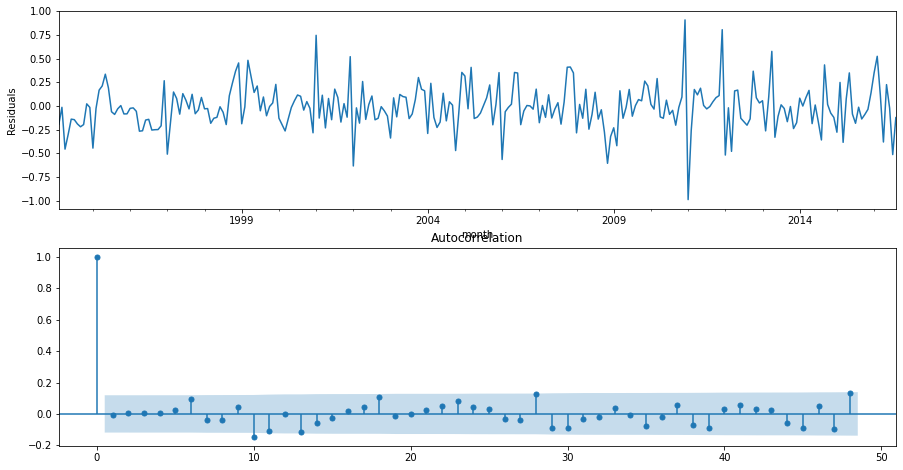

In [21]:
plt.figure(figsize = (15, 8))

plt.subplot(2, 1, 1)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values, lags = 48, ax = ax)
plt.show()

###  Несмещенность

Критерий Стьюдента для проверки несмещенности остатков.

In [22]:
stats.ttest_1samp(best_model.resid[13:], 0)[1]

c:\users\owner\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.296175702462887

Несмещенность не отвергается.

### Стационарность

Визуально ряд остатков стационарен. Проверим стационарность формально с помощью критерия Дики-Фуллера.

In [23]:
sm.tsa.stattools.adfuller(best_model.resid[13:].values)[1]

1.9783849629314153e-29

Нестационарность уверенно отвергается

### Автокорреляция

График показывает значимую автокорреляцию только для одного несезонного лага (10). Можно считать, что это следствие множественной проверки гипотез. Также неавтокоррелированность остатков не отвергается критерием Люнга-Бокса. Это видно из таблицы выше.

# Прогноз

Составим прогноз на следующие два года после последней записи.

c:\users\owner\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


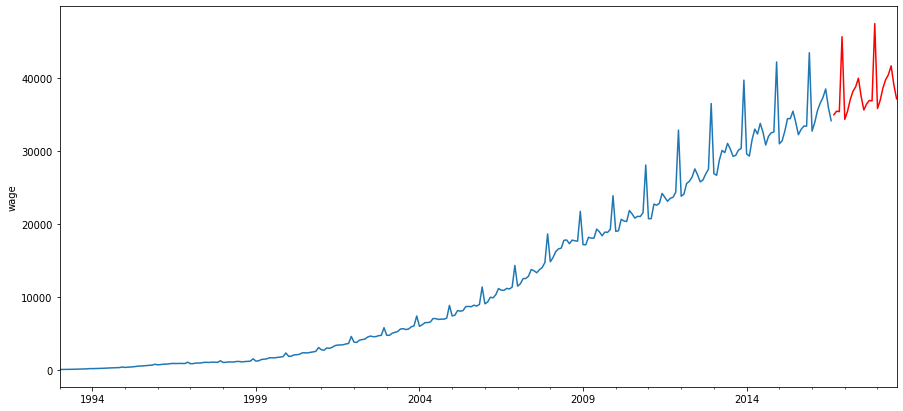

In [24]:
data2 = data[['wage']]
date_list = [datetime.datetime.strptime('2016-09-01', '%Y-%m-%d') +
             relativedelta(months = x) for x in range(24)]
future = pd.DataFrame(index = date_list, columns = data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start = date_list[0], end = date_list[-1]), lambda_)

plt.figure(figsize = (15, 7))
data2.wage.plot()
data2.forecast.plot(color = 'r')
plt.ylabel('wage')
plt.show()